# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [1]:
# Откроем данные

import pandas as pd
import numpy as np

data = pd.read_csv('data/spam_or_not_spam.csv')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [2]:
# Рассчитаем частоты для классов

print(data['label'].value_counts())
data['label'].value_counts(normalize=True)

label
0    2500
1     500
Name: count, dtype: int64


label
0    0.833333
1    0.166667
Name: proportion, dtype: float64

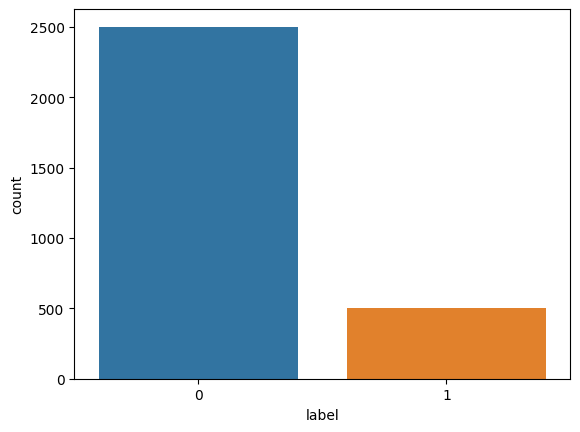

In [3]:
# Визуализируем результат

import seaborn as sns

sns.countplot(data=data, x='label');

##### Вывод: на графике видно, что наблюдается несбалансированность классов.

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [5]:
# Удалим пустые строки и строки, состоящие из пробелов с помощью масок

data = data[(data['email'].isnull()!=True) & (data['email']!=" ")]

Переводим данные в векторный вид:

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [7]:
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [8]:
X = X.toarray()
y = data['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [9]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y,
    test_size=0.25, 
    random_state=42
)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [10]:
round(y_test.mean(), 3)

0.165

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [11]:
# Будем использовать алгоритм ComplementNB

from sklearn.naive_bayes import ComplementNB

alpha=0.01

complement_nb = ComplementNB(alpha=alpha)
complement_nb.fit(X_train, y_train)
y_train_pred = complement_nb.predict(X_train)
y_test_pred = complement_nb.predict(X_test)
y_test_pred_proba = complement_nb.predict_proba(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [12]:
from sklearn import metrics

print('Accuracy:', round(metrics.accuracy_score(y_test, y_test_pred), 3))
print('Precision:', round(metrics.precision_score(y_test, y_test_pred), 3))
print('Recall:', round(metrics.recall_score(y_test, y_test_pred), 3))
print('F1-score:', round(metrics.f1_score(y_test, y_test_pred), 3))

Accuracy: 0.988
Precision: 1.0
Recall: 0.927
F1-score: 0.962


Нарисуйте ROC-кривую:

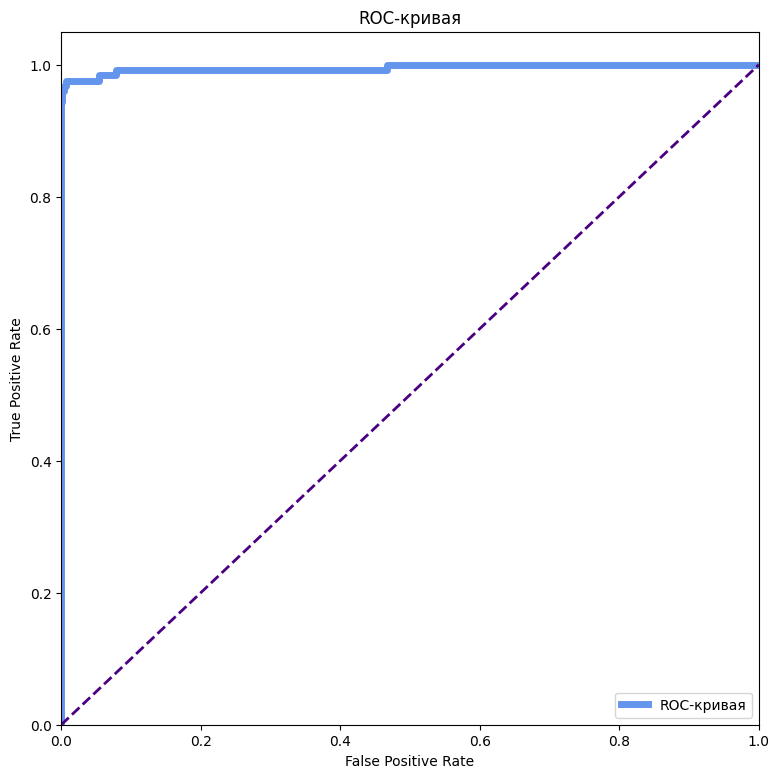

In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, y_test_pred_proba[:,1], drop_intermediate=False)

plt.figure(figsize=(9, 9))
plt.plot(false_positive_rates, true_positive_rates, color="cornflowerblue", lw=5,  label="ROC-кривая")
plt.plot([0, 1], [0, 1], color="indigo", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend(loc="lower right")
plt.show();

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [14]:
from sklearn import naive_bayes
from sklearn.model_selection import cross_validate

metrics_list = []

for i in list(np.linspace(0.01, 0.1, 10, dtype=float)):

    # Создаём модель
    model = naive_bayes.ComplementNB(alpha=i)
 
    # Создаём объект кросс-валидатора KFold
    kf = model_selection.KFold(n_splits=5)
 
    # Считаем метрики на кросс-валидации k-fold
    cv_metrics = cross_validate(
        estimator=model, # модель
        X=X, # матрица наблюдений X
        y=y, # вектор ответов y
        cv=kf, # кросс-валидатор
        scoring='accuracy', # метрика
        return_train_score=True 
    )
    metrics_list.append((np.mean(cv_metrics['test_score'])))

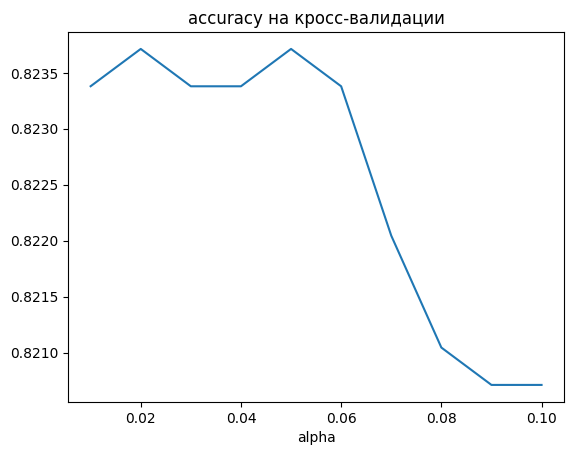

In [15]:
# Рисуем график

lpt=sns.lineplot(
    x=list(np.linspace(0.01, 0.1, 10, dtype=float)),
    y=metrics_list
)
lpt.set(title='accuracy на кросс-валидации', xlabel='alpha');

##### Вывод:
##### На графике метрики качества видно, что после alpha=0.05 идёт ухудшение метрики accuracy, а следовательно и качества классификации. Из этого можно сделать вывод, что от параметра alpha зависит качество классификации.